In [1]:
import pandas as pd
import plotly.express as px

columns = [
        'join_id','dt','chain', 'active_secs_per_day'
        ,'num_l1_txs_inbox','num_l1_txs_output','calldata_bytes_l1_inbox'
        ,'avg_l1_gas_price_on_l1_inbox','avg_l1_gas_price_on_l1_output','avg_l1_gas_price_on_l2'
        ,'l1_gas_used_inbox','l1_gas_used_output','l1_gas_used_combined'
        ,'l1_eth_fees_inbox','l1_eth_fees_output','l1_eth_fees_combined'
        ,'l1_contrib_l2_eth_fees_per_day','l2_contrib_l2_eth_fees_per_day'
        # ,'l2_num_raw_txs_per_day'
        ,'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
        ,'l1_gas_used_on_l2','calldata_bytes_l2_per_day'
        ,'l1_gas_used_user_txs_l2_per_day','calldata_bytes_user_txs_l2_per_day'
        ,'l2_gas_used','l2_eth_fees_per_day'
        ]

In [2]:
#Unify datasets
dunedf = pd.read_csv('csv_inputs/op_chain_gas_economics_dune_query_2453515_dt2023_09_12.csv') #https://dune.com/queries/2453515 --last 90 days
goldskydf = pd.read_csv('csv_inputs/op_chain_gas_economics_goldsky_zora_pgn_dt2023_09_12.csv') #requires auth - https://dash.goldsky.com/question/9-op-chains-activity-by-period

In [3]:
# Map Chain Names
chain_mappings = {
    'zora': 'Zora Network',
    'pgn': 'Public Goods Network',
    # Add more mappings as needed
}
goldskydf['chain'] = goldskydf['chain'].replace(chain_mappings)

In [4]:
#Configure
#rename cols
dunedf = dunedf.rename(columns={
                        'name':'chain'
                        })
#Generate Join ID Column
dunedf['join_id'] = dunedf['dt'].astype(str).str[:10].str.cat(dunedf['chain'].astype(str).str.lower())
goldskydf['join_id'] = goldskydf['dt'].astype(str).str[:10].str.cat(goldskydf['chain'].astype(str).str.lower())

# display(dunedf.head(10))
# print(dunedf.columns)
# print('---')
# display(goldskydf.head(10))
# print(goldskydf.columns)

combo_df = dunedf.merge(goldskydf, on='join_id', how='left')

# display(combo_df)

for c in columns:
        try:
                combo_df[c] = combo_df[c+'_x'].combine_first(combo_df[c+'_y']) #pick first non-null
        except:
                combo_df[c] = combo_df[c] #nada

combo_df['dt'] = pd.to_datetime(combo_df['dt'])
combo_df = combo_df[columns]

combo_df['gas_compression_ratio'] = combo_df['l1_gas_used_inbox'] / combo_df['l1_gas_used_on_l2']
combo_df['bytes_compression_ratio'] = combo_df['calldata_bytes_l1_inbox'] / combo_df['calldata_bytes_l2_per_day']
combo_df['dt_rank'] = combo_df['dt'].rank(method='dense', ascending=False).astype('int')

In [5]:
display( combo_df.sample(5) )

combo_df.to_csv('outputs/op_chain_gas_economics_sample.csv')

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l1_gas_used_user_txs_l2_per_day,calldata_bytes_user_txs_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
204,2023-07-23op mainnet,2023-07-23 00:00:00+00:00,OP Mainnet,86400.0,896,24,99277171.0,19.049030,20.517196,18.817659,...,694.0,2.925933e+09,274436017.0,2.925933e+09,262938393.0,1.386572e+11,43.861803,0.547804,0.361750,52
181,2023-07-29base,2023-07-29 00:00:00+00:00,Base,86400.0,1448,24,6570856.0,21.165227,21.651625,20.368042,...,5.0,1.343467e+08,19591391.0,1.343467e+08,8357579.0,5.909052e+09,6.980349,1.005743,0.335395,46
132,2023-08-10op mainnet,2023-08-10 00:00:00+00:00,OP Mainnet,86400.0,941,24,104624041.0,22.303333,20.968231,22.217214,...,490.0,2.683538e+09,222228031.0,2.683538e+09,210786711.0,1.551176e+11,51.283911,0.629394,0.470796,34
5,2023-09-11base,2023-09-11 00:00:00+00:00,Base,86400.0,1457,24,74136720.0,20.164921,19.820157,19.648453,...,1369.0,2.005230e+09,117479586.0,2.005230e+09,105634840.0,2.209578e+11,45.676095,0.604907,0.631060,2
302,2023-06-25base,2023-06-25 00:00:00+00:00,Base,86400.0,1422,24,2036390.0,13.049591,12.871351,NaN,...,0.0,NaN,11232000.0,0.000000e+00,0.0,2.168957e+09,0.000000,NaN,0.181303,80


In [6]:
bl_gas_ratio = combo_df['l1_gas_used_inbox'].sum() / combo_df['l1_gas_used_on_l2'].sum()
bl_bytes_ratio = combo_df['calldata_bytes_l1_inbox'].sum() / combo_df['calldata_bytes_l2_per_day'].sum()
print('Blended gas compression ratio: ' + str(round(bl_gas_ratio*100,1)) + '%')
print('Blended bytes compression ratio: ' + str(round(bl_bytes_ratio*100,1)) + '%')

Blended gas compression ratio: 63.2%
Blended bytes compression ratio: 44.6%


In [7]:
# Create the scatter plot
combo_df_plot = combo_df[
                        (~combo_df['gas_compression_ratio'].isna()) 
                         & (combo_df['gas_compression_ratio']<1) 
                         & (combo_df['active_secs_per_day'] == 86400)
                         ]

# combo_df_plot = combo_df[(~combo_df['bytes_compression_ratio'].isna())
#                          & (combo_df['active_secs_per_day'] == 86400)]

display(combo_df_plot)

fig = px.scatter(combo_df_plot,
                 x='l1_gas_used_user_txs_l2_per_day',#'l1_gas_used_on_l2',
                 y='l1_gas_used_inbox',
                 size = 'gas_compression_ratio',
                 color='chain',
                 title='L1 Gas Used on each Layer by chain')

# Display the plot
fig.show()

##############

fig_bytes = px.scatter(combo_df_plot,
                 x='calldata_bytes_user_txs_l2_per_day',#'calldata_bytes_l2_per_day',
                 y='calldata_bytes_l1_inbox',
                 size = 'bytes_compression_ratio',
                 color='chain',
                 title='Calldata Bytes on each Layer by chain')

fig_bytes.show()

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l1_gas_used_user_txs_l2_per_day,calldata_bytes_user_txs_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
0,2023-09-12op mainnet,2023-09-12 00:00:00+00:00,OP Mainnet,86400.0,937,24,108578898.0,15.179670,13.947146,1.487507e+01,...,316.0,2.479246e+09,190761361.0,2.479246e+09,179396001.0,1.830403e+11,39.093185,0.706456,0.569187,1
1,2023-09-12base,2023-09-12 00:00:00+00:00,Base,86400.0,1490,24,86724354.0,15.822131,14.305780,1.582074e+01,...,2129.0,2.463781e+09,132188241.0,2.463781e+09,119999666.0,2.210003e+11,45.142012,0.574015,0.656067,1
2,2023-09-12zora network,2023-09-12 00:00:00+00:00,Zora Network,86400.0,157,24,12908057.0,14.606068,15.946554,9.299600e+09,...,9.0,3.019689e+08,27750891.0,3.019689e+08,16512687.0,1.473490e+10,5.818694,0.692815,0.465140,1
4,2023-09-11op mainnet,2023-09-11 00:00:00+00:00,OP Mainnet,86400.0,1142,24,130186031.0,21.269062,22.813770,2.091096e+01,...,269.0,2.724059e+09,211322746.0,2.724059e+09,199977062.0,1.932994e+11,63.776074,0.771064,0.616053,2
5,2023-09-11base,2023-09-11 00:00:00+00:00,Base,86400.0,1457,24,74136720.0,20.164921,19.820157,1.964845e+01,...,1369.0,2.005230e+09,117479586.0,2.005230e+09,105634840.0,2.209578e+11,45.676095,0.604907,0.631060,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2023-06-19op mainnet,2023-06-19 00:00:00+00:00,OP Mainnet,86400.0,698,24,74624959.0,19.288669,18.460803,1.914016e+01,...,298.0,1.994122e+09,172234132.0,1.994122e+09,160877196.0,1.587398e+11,29.532276,0.604424,0.433276,86
322,2023-06-18op mainnet,2023-06-18 00:00:00+00:00,OP Mainnet,86400.0,635,24,68155267.0,15.473068,15.447195,1.524186e+01,...,354.0,1.854493e+09,162701654.0,1.854493e+09,151321614.0,1.160427e+11,21.997722,0.593569,0.418897,87
325,2023-06-17op mainnet,2023-06-17 00:00:00+00:00,OP Mainnet,86400.0,671,24,71588096.0,17.302002,17.057154,1.714780e+01,...,336.0,1.925738e+09,168555774.0,1.925738e+09,157181302.0,1.162697e+11,25.571378,0.600443,0.424715,88
328,2023-06-16op mainnet,2023-06-16 00:00:00+00:00,OP Mainnet,86400.0,726,24,78383983.0,20.268090,17.725746,2.000091e+01,...,411.0,2.115517e+09,182728388.0,2.115517e+09,171322200.0,1.241124e+11,34.695250,0.598371,0.428964,89


In [8]:
new_data = combo_df[combo_df['active_secs_per_day'] == 86400].copy()
display(new_data.sample(5))

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l1_gas_used_user_txs_l2_per_day,calldata_bytes_user_txs_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
300,2023-06-26zora network,2023-06-26 00:00:00+00:00,Zora Network,86400.0,146,24,2633933.0,13.928237,14.165730,1.640314e+09,...,0.0,2.410397e+07,12673620.0,2.410397e+07,1441620.0,3.055600e+09,1.388103,1.871420,0.207828,79
247,2023-07-13public goods network,2023-07-13 00:00:00+00:00,Public Goods Network,86400.0,145,24,1880473.0,31.766410,29.459902,2.879330e+07,...,6.0,6.205240e+05,11273837.0,6.205240e+05,39317.0,2.182700e+09,0.050452,53.311962,0.166800,62
279,2023-07-03zora network,2023-07-03 00:00:00+00:00,Zora Network,86400.0,145,24,2385654.0,20.119401,19.819444,1.849567e+09,...,1.0,1.547497e+07,11983258.0,1.547497e+07,750730.0,2.819320e+09,1.088775,2.657958,0.199082,72
246,2023-07-13zora network,2023-07-13 00:00:00+00:00,Zora Network,86400.0,145,24,2315343.0,31.092742,31.686849,8.889537e+08,...,0.0,1.064406e+07,11978313.0,1.064406e+07,746313.0,2.770717e+09,0.956875,3.759335,0.193295,62
322,2023-06-18op mainnet,2023-06-18 00:00:00+00:00,OP Mainnet,86400.0,635,24,68155267.0,15.473068,15.447195,1.524186e+01,...,354.0,1.854493e+09,162701654.0,1.854493e+09,151321614.0,1.160427e+11,21.997722,0.593569,0.418897,87


In [9]:
selected_columns = [
    'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
    , 'l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l1_gas_used_user_txs_l2_per_day'
    , 'calldata_bytes_user_txs_l2_per_day', 'l1_gas_used_inbox'
]

missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                    0
l2_num_attr_deposit_txs_per_day       0
l2_num_user_deposit_txs_per_day       0
l1_gas_used_on_l2                     9
calldata_bytes_l2_per_day             0
l1_gas_used_user_txs_l2_per_day       0
calldata_bytes_user_txs_l2_per_day    0
l1_gas_used_inbox                     0
dtype: int64

In [10]:
# Filling the missing values in 'l1_gas_used_on_l2' with 0
new_data['l1_gas_used_on_l2'].fillna(0, inplace=True)
new_data['calldata_bytes_l2_per_day'].fillna(0, inplace=True)
new_data['l1_gas_used_user_txs_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_bytes_user_txs_l2_per_day'].fillna(0, inplace=True)

# Verifying that there are no more missing values in the selected columns
missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                    0
l2_num_attr_deposit_txs_per_day       0
l2_num_user_deposit_txs_per_day       0
l1_gas_used_on_l2                     0
calldata_bytes_l2_per_day             0
l1_gas_used_user_txs_l2_per_day       0
calldata_bytes_user_txs_l2_per_day    0
l1_gas_used_inbox                     0
dtype: int64

In [11]:
# Step 2: Feature Selection - Examining the correlation between the potential features and the target variable
correlation_matrix = new_data[selected_columns].corr()

# Getting the correlation of all features with the target variable 'l1_gas_used_inbox'
target_correlation = correlation_matrix['l1_gas_used_inbox']

# Displaying the correlation values
target_correlation

l2_num_txs_per_day                    0.957534
l2_num_attr_deposit_txs_per_day      -0.043606
l2_num_user_deposit_txs_per_day       0.439267
l1_gas_used_on_l2                     0.995739
calldata_bytes_l2_per_day             0.979816
l1_gas_used_user_txs_l2_per_day       0.995739
calldata_bytes_user_txs_l2_per_day    0.979453
l1_gas_used_inbox                     1.000000
Name: l1_gas_used_inbox, dtype: float64

In [12]:
# Build new values
new_data['l1_gas_used_per_user_tx'] = new_data['l1_gas_used_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['calldata_bytes_per_user_tx'] = new_data['calldata_bytes_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']

# display(new_data[new_data['l1_gas_used_user_txs_l2_per_day'] == 0].head(5))

new_data['l1_gas_used_per_user_tx'].fillna(0, inplace=True)
new_data['calldata_bytes_per_user_tx'].fillna(0, inplace=True)

# new_data['l2_num_txs_per_day_sq'] = new_data['l2_num_txs_per_day'] ** 2

# display(new_data.head(5))

In [13]:
# GPT Built model
from sklearn.model_selection import train_test_split

# Step 3: Data Splitting - Splitting the data into training and testing sets

# Selected features
features = [
    # 'l1_gas_used_user_txs_l2_per_day', 
    # 'calldata_bytes_user_txs_l2_per_day', 
    'l1_gas_used_per_user_tx',
    'calldata_bytes_per_user_tx',
    'l2_num_txs_per_day', 
    # 'l2_num_txs_per_day_sq', 
    'l2_num_user_deposit_txs_per_day', 
    # 'l2_num_attr_deposit_txs_per_day'
]

# Target variable
target = 'l1_gas_used_inbox'

# Splitting the data into training and testing sets (80% training, 20% testing)
X = new_data[features]
y = new_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((264, 4), (67, 4))

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 4: Model Training - Training a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Step 5: Model Evaluation - Evaluating the model on the testing set
y_pred_linear = linear_regressor.predict(X_test)

# Calculate the model performance
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_linear, r2_linear

(3.473848217206797e+16, 0.9309091843179128)

In [15]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor.intercept_
coefficients = linear_regressor.coef_

# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(20027644.59153402,
 {'l1_gas_used_per_user_tx': -26352.518689322624,
  'calldata_bytes_per_user_tx': 407480.067736702,
  'l2_num_txs_per_day': 3312.505934284418,
  'l2_num_user_deposit_txs_per_day': -185882.4317124722})

In [16]:
from joblib import dump

# Save the model to a file
model_filepath = 'outputs/linear_regression_l1_gas_used_inbox_model.joblib'
dump(linear_regressor, model_filepath)


['outputs/linear_regression_l1_gas_used_inbox_model.joblib']

In [17]:
# Create a string to represent the regression equation
equation_str = f"l1_gas_used_inbox = {intercept:.2f}"
for feature, coef in feature_coeff_dict.items():
    equation_str += f" + ({coef:.2f}) * {feature}"

# Print out the regression equation
print(equation_str)

l1_gas_used_inbox = 20027644.59 + (-26352.52) * l1_gas_used_per_user_tx + (407480.07) * calldata_bytes_per_user_tx + (3312.51) * l2_num_txs_per_day + (-185882.43) * l2_num_user_deposit_txs_per_day


In [18]:
# Find inputs
# Convert the 'dt' column to datetime data type
new_data['dt'] = pd.to_datetime(new_data['dt'])

# Identify the most recent date in the dataset
most_recent_date = new_data['dt'].max()

# Identify the date that is 30 days before the most recent date
date_30_days_ago = most_recent_date - pd.Timedelta(days=30)

# Filter the data to include only the most recent 30 days
recent_30_days_data = new_data[new_data['dt'] > date_30_days_ago]

# Group the data by 'chain' and calculate the average values for each of the input features over the most recent 30 days
average_values_per_chain = recent_30_days_data.groupby('chain')[features].mean()

# Resetting the index to have 'chain' as a column
average_values_per_chain = average_values_per_chain.reset_index()

# Calculate the per transaction values for 'l1_gas_used_on_l2' and 'calldata_bytes_l2_per_day'
# average_values_per_chain['l1_gas_used_user_txs_on_l2_per_tx'] = average_values_per_chain['l1_gas_used_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']
# average_values_per_chain['calldata_bytes_user_txs_l2_per_tx'] = average_values_per_chain['calldata_bytes_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']

# Create a new DataFrame to hold the 'per_tx' values
# average_values_per_tx_chain = average_values_per_chain[['chain', 'l1_gas_used_per_user_tx', 'calldata_bytes_per_user_tx', 'l2_num_txs_per_day']]



# Display the average values per chain
# display(average_values_per_tx_chain)

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_93720/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_93720/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_93720/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

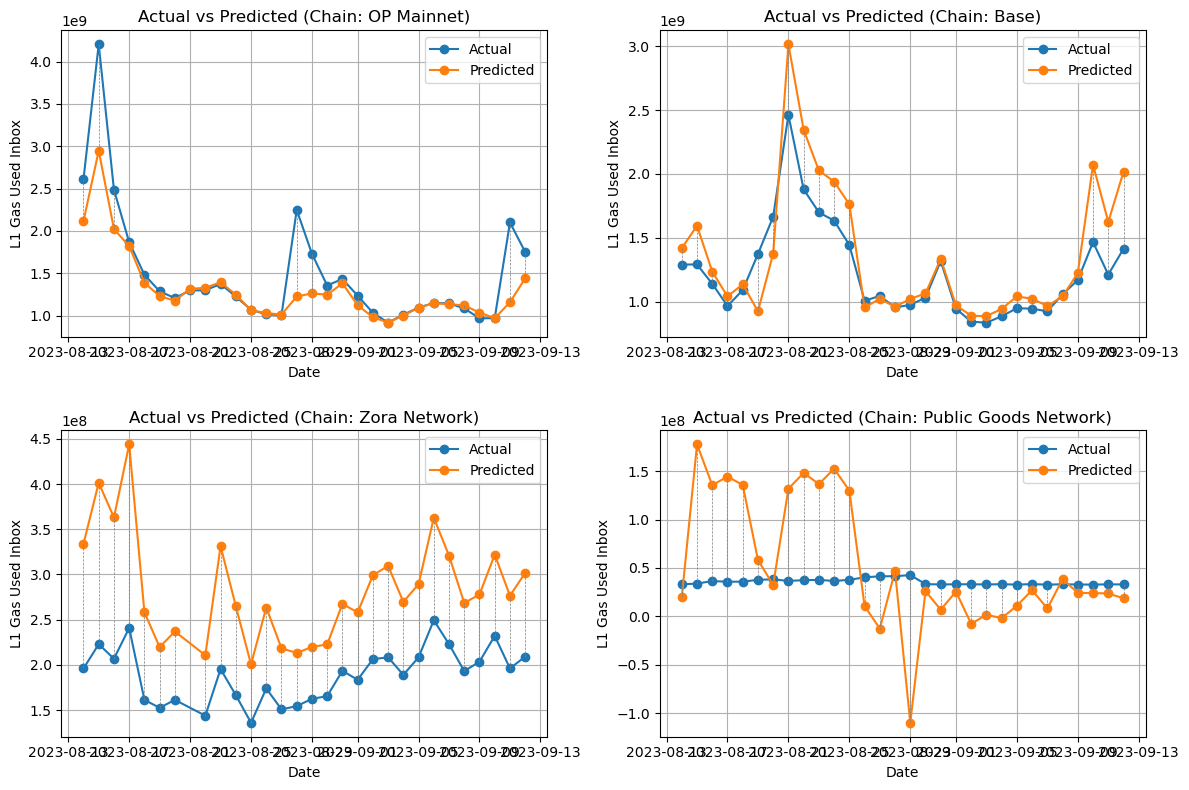

In [19]:
import matplotlib.pyplot as plt
# Setting up the plot
plt.figure(figsize=(12, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain
    chain_data = recent_30_days_data[recent_30_days_data['chain'] == chain]
    
    # Making predictions using the new model
    chain_data['predicted_l1_gas_used_inbox_new'] = linear_regressor.predict(chain_data[features])
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_new'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox_new'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain})')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


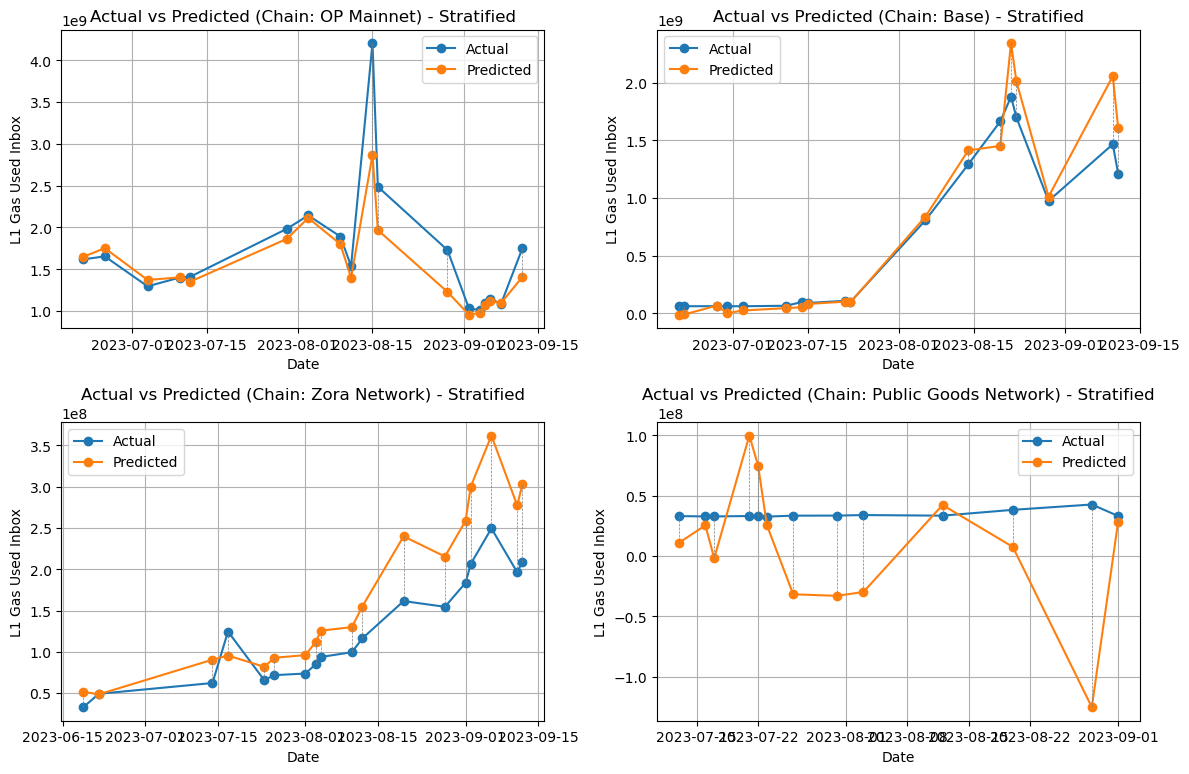

In [20]:
#Stratify sampling

from sklearn.model_selection import StratifiedShuffleSplit

# Resetting the index of new_data before performing stratified sampling
new_data.reset_index(drop=True, inplace=True)

# Defining the stratified shuffle split object to split the data into training and testing sets with stratification on the 'chain' column
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# Splitting the data into training and testing sets using stratified sampling
for train_index, test_index in stratified_split.split(new_data, new_data['chain']):
    stratified_train_data = new_data.loc[train_index]
    stratified_test_data = new_data.loc[test_index]

# Training the linear regression model using the stratified training set
X_train_stratified = stratified_train_data[features]
y_train_stratified = stratified_train_data['l1_gas_used_inbox']
X_test_stratified = stratified_test_data[features]
y_test_stratified = stratified_test_data['l1_gas_used_inbox']

linear_regressor_stratified = LinearRegression()
linear_regressor_stratified.fit(X_train_stratified, y_train_stratified)

# Predicting the target variable on the stratified testing set
stratified_test_data['predicted_l1_gas_used_inbox'] = linear_regressor_stratified.predict(X_test_stratified)

# Setting up the plot for visualization of residuals for each chain
plt.figure(figsize=(12, 8))

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain and sorting it by date for a connected line plot
    chain_data = stratified_test_data[stratified_test_data['chain'] == chain].sort_values(by='dt')
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain}) - Stratified')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [21]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor_stratified.intercept_
coefficients = linear_regressor_stratified.coef_

# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(25482410.20244956,
 {'l1_gas_used_per_user_tx': -19223.985692986775,
  'calldata_bytes_per_user_tx': 297206.1299151965,
  'l2_num_txs_per_day': 3225.300777630997,
  'l2_num_user_deposit_txs_per_day': -167693.34370668084})

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# Step 1: Create second-degree polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(new_data[features])

# Step 2: Train a linear regression model using the polynomial features
poly_lr = LinearRegression()
poly_lr.fit(X_poly, new_data['l1_gas_used_inbox'])

# Step 3: Make predictions using the polynomial features
new_data['predicted_l1_gas_used_inbox_poly'] = poly_lr.predict(X_poly)

# Step 4: Evaluate the model using suitable metrics
mse_poly = mean_squared_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
mae_poly = mean_absolute_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
r2_poly = r2_score(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])

mse_poly, mae_poly, r2_poly


(2073330738447045.5, 25983890.235470627, 0.9965002163119112)

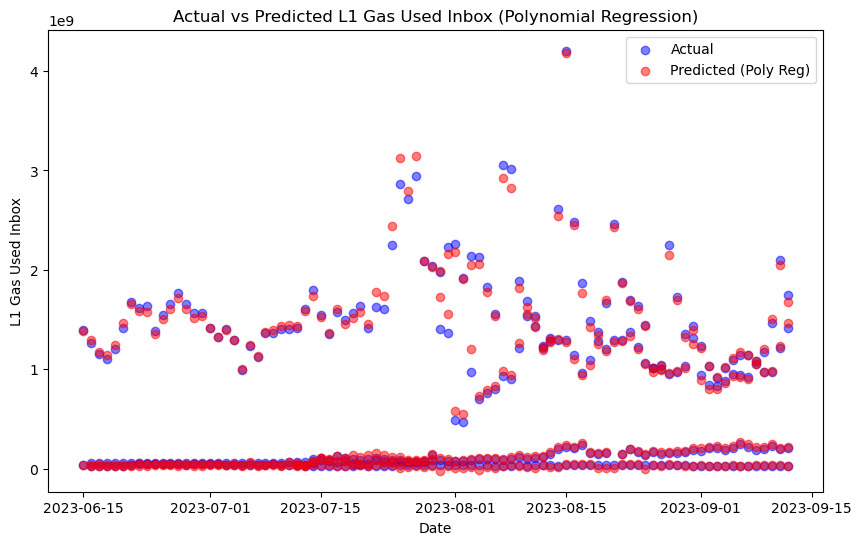

In [23]:
# Visualizing the actual vs predicted values for the model with polynomial features
plt.figure(figsize=(10, 6))

# Plotting the actual values
plt.scatter(new_data['dt'], new_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')

# Plotting the predicted values from the polynomial regression model
plt.scatter(new_data['dt'], new_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')

# Labeling the axes and setting the title
plt.xlabel('Date')
plt.ylabel('L1 Gas Used Inbox')
plt.title('Actual vs Predicted L1 Gas Used Inbox (Polynomial Regression)')

# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()


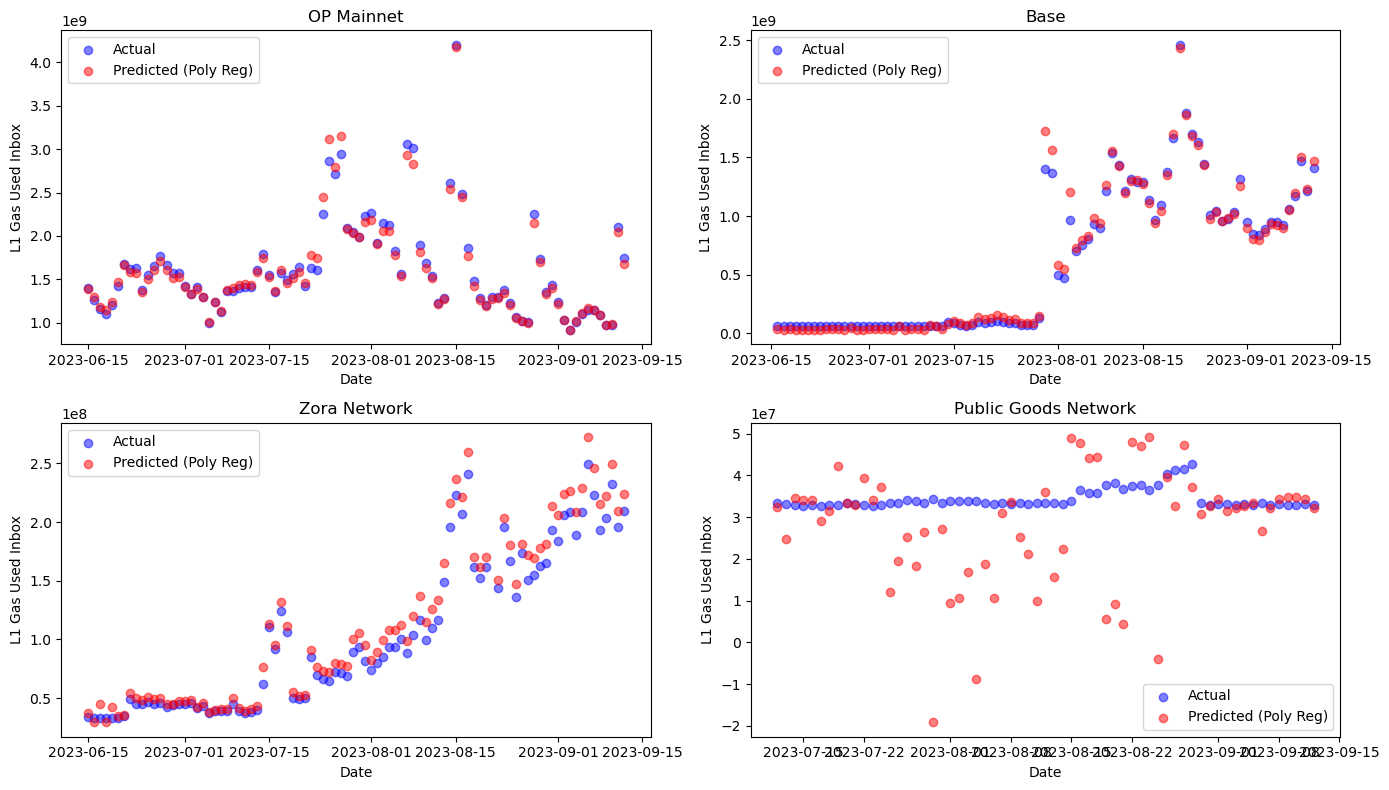

In [24]:
# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Plotting the actual and predicted values for each chain in separate subplots
for i, chain in enumerate(chains, 1):
    plt.subplot(2, 2, i)
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Plotting the actual values
    plt.scatter(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')
    
    # Setting the title to the current chain
    plt.title(chain)
    
    # Labeling the axes
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'outputs/op_chain_gas_economics_sample.csv'
data = pd.read_csv(file_path)

# Create the 'full_days_data' dataframe by filtering rows where 'active_secs_per_day' is equal to the maximum value
max_active_secs = data['active_secs_per_day'].max()
full_days_data = data[data['active_secs_per_day'] == max_active_secs]

# Create new features representing gas used and calldata bytes per user transaction
full_days_data['l1_gas_used_per_user_tx'] = full_days_data['l1_gas_used_user_txs_l2_per_day'] / full_days_data['l2_num_txs_per_day']
full_days_data['calldata_bytes_per_user_tx'] = full_days_data['calldata_bytes_user_txs_l2_per_day'] / full_days_data['l2_num_txs_per_day']

# Fill NaN values with 0
full_days_data['l1_gas_used_per_user_tx'].fillna(0, inplace=True)
full_days_data['calldata_bytes_per_user_tx'].fillna(0, inplace=True)

# Find the minimum 'l1_gas_used_inbox' value for days with zero transactions and set it as a new feature
min_gas_used_inbox = full_days_data.loc[full_days_data['l2_num_txs_per_day'] == 0, 'l1_gas_used_inbox'].min()
full_days_data['min_gas_used_inbox'] = min_gas_used_inbox

# Define features and target variable
features = [
    'l1_gas_used_per_user_tx',
    'calldata_bytes_per_user_tx',
    'l2_num_txs_per_day', 
    'l2_num_user_deposit_txs_per_day',
    'min_gas_used_inbox'
]
target = 'l1_gas_used_inbox'

# Split the data into training and testing sets
X = full_days_data[features]
y = full_days_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = linear_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model performance metrics
print(f"MSE: {mse}")
print(f"R²: {r2}")



MSE: 3.473848217206797e+16
R²: 0.9309091843179128


/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_93720/1465728682.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_93720/1465728682.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_93720/1465728682.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [34]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor.intercept_
coefficients = linear_regressor.coef_

# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(20027644.59153402,
 {'l1_gas_used_per_user_tx': -26352.518689322624,
  'calldata_bytes_per_user_tx': 407480.067736702,
  'l2_num_txs_per_day': 3312.505934284418,
  'l2_num_user_deposit_txs_per_day': -185882.4317124722,
  'min_gas_used_inbox': 0.0})

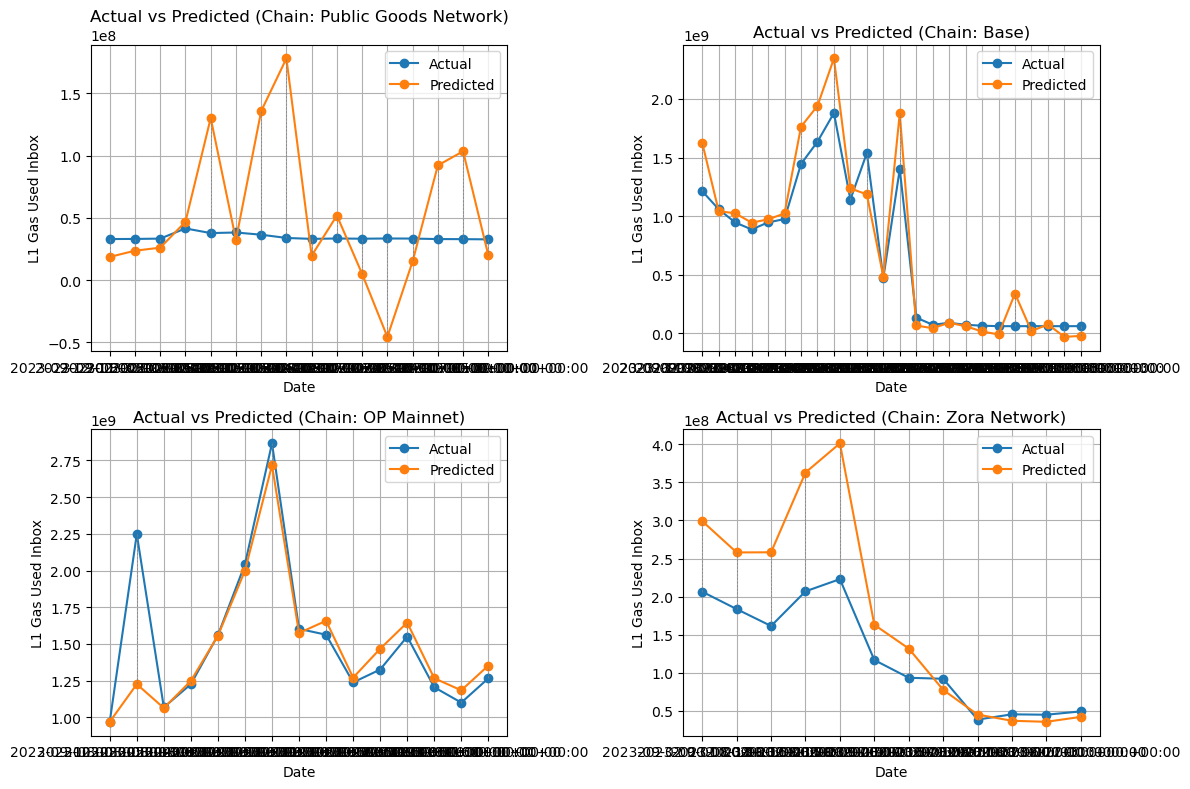

In [32]:
# Setting up the plot
plt.figure(figsize=(12, 8))

# Adding a column to the testing set to store the predictions
X_test['predicted_l1_gas_used_inbox'] = y_pred

# Merging with the full dataset to get the 'chain' and 'dt' columns for plotting
test_data_with_predictions = full_days_data.merge(X_test[['predicted_l1_gas_used_inbox']], left_index=True, right_index=True)

# List of unique chains
chains = test_data_with_predictions['chain'].unique()

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain
    chain_data = test_data_with_predictions[test_data_with_predictions['chain'] == chain]
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain})')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


R² Score: -30.011281750615442


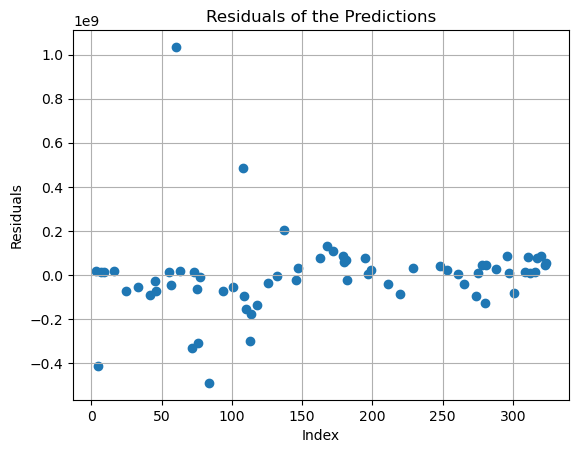

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = 'outputs/op_chain_gas_economics_sample.csv'
data = pd.read_csv(file_path)

# Create interaction terms
features = [
    'l2_num_txs_per_day', 
    'l2_num_attr_deposit_txs_per_day', 
    'l2_num_user_deposit_txs_per_day',
    'l1_gas_used_user_txs_l2_per_day',
    'calldata_bytes_user_txs_l2_per_day',
    'l2_gas_used'
]

interaction_terms = []
for i, feature1 in enumerate(features):
    for feature2 in features[i+1:]:
        interaction_term = f"{feature1}_x_{feature2}"
        data[interaction_term] = data[feature1] * data[feature2]
        interaction_terms.append(interaction_term)

# Display the interaction terms
interaction_terms
